In [97]:
import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt
import torch
from torch import nn
np.set_printoptions(linewidth=200)

# Synthetic Data Generation

In [98]:
# Synthetic problem
r = np.random.random((12,3))
s = np.random.random((40,3))

q = np.sqrt(np.sum((np.expand_dims(r,1) - np.expand_dims(s,0))**2,axis=2))
offsets_gt = np.random.rand(1,q.shape[1])
q = q + offsets_gt + 0.01*np.random.randn(*q.shape)
outlier_idx = np.random.rand(*q.shape) < 0.1
q[outlier_idx] = np.random.rand(*q.shape)[outlier_idx]*3

tdoa_df = pd.DataFrame(q)
tdoa = tdoa_df.to_numpy()
tdoa_df

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.607232,1.565608,1.035450,1.008170,1.319104,1.109555,0.758569,1.984607,1.493852,1.741844,...,1.570412,2.844279,1.695400,1.202330,1.097215,0.740782,1.182099,0.491086,1.004986,1.563259
1,1.016244,1.080515,1.609007,1.135106,0.736300,0.554275,0.742077,1.598750,1.465399,1.935552,...,1.292472,1.470018,1.591659,1.287422,0.633848,0.771387,1.131035,1.143905,0.635074,1.027864
2,1.033054,1.658783,1.623084,2.043681,1.066976,0.749352,1.141629,1.248328,1.766530,0.699295,...,1.664115,1.549461,2.022616,1.689088,1.193918,0.880843,1.538095,1.296462,0.809593,1.435881
3,0.922828,0.741672,1.464949,0.783477,0.825198,0.597690,0.672696,1.602569,1.311773,1.754085,...,1.223433,1.529353,1.497616,1.209735,0.768256,0.569749,2.741685,0.985140,0.579720,1.069216
4,1.002395,1.119342,1.506840,0.724327,0.806971,0.694723,0.462696,1.727052,1.202569,1.754465,...,1.091003,1.634953,1.340275,1.156512,0.755734,0.627538,0.875760,0.951697,0.548320,1.002748
5,1.126213,1.080815,1.590792,0.554012,1.065518,1.028136,0.622728,2.125781,1.336970,2.012953,...,1.256156,2.738523,1.218203,1.008549,0.715202,0.955226,0.890025,0.930553,0.861614,1.228339
6,1.471747,1.120955,2.009640,1.506466,1.048636,1.015166,1.099409,2.072064,1.993440,2.524793,...,1.744662,1.912617,1.267649,1.571293,0.492817,1.344012,1.571715,1.571794,1.196446,1.370258
7,0.723661,1.283495,1.193370,0.939461,1.138526,0.939770,0.507597,1.885916,1.382803,1.821247,...,1.394137,1.832350,0.466954,1.874862,0.847722,0.659510,1.001051,0.667271,0.848049,1.359263
8,0.727548,2.155581,1.310358,0.947715,1.037183,0.748824,0.701981,1.631513,1.508430,1.798359,...,1.446429,1.741542,1.686289,1.258862,0.890353,0.599578,1.189300,0.913162,0.787507,1.283031
9,1.069928,1.333498,1.541801,0.642475,1.014106,0.974688,1.924804,1.954223,0.998347,1.657603,...,1.087916,1.867727,1.241666,1.251646,1.008764,0.740079,2.998041,0.302184,0.656259,0.031061


# Helper Functions ans Classes

In [99]:
class UvaboSolution():

    def __init__(self, n_receivers, n_senders, dim=3):
        u = np.empty((3, n_receivers))
        u[:] = np.nan
        self.u = u

        v = np.empty((3, n_senders))
        v[:] = np.nan
        self.v = v

        a = np.empty((n_receivers,1))
        a[:] = np.nan
        self.a = a

        b = np.empty((1, n_senders))
        b[:] = np.nan
        self.b = b

        o = np.empty((1,n_senders))
        o[:] = np.nan
        self.o = o

from enum import Enum
from abc import ABC, abstractmethod

def init_uvab(d):
    dsquare = d**2
    doubleCompaction = dsquare - dsquare[0:1,:] - dsquare[:,0:1] + dsquare[0,0]
    uu,ss,vv = np.linalg.svd(doubleCompaction/-2)
    u =uu[:,:3].T
    v = np.diag(ss[:3])@vv[:3,:]
    a = dsquare[:,0:1] - dsquare[0,0]/2
    b = dsquare[0:1,:] - dsquare[0,0]/2
    return u,v,a,b

class TxoaType(Enum):
    TOA = 1
    TDOA = 2
    COTDOA = 3

class TxoaProblem():
    def __init__(self, data, problem_type=TxoaType.TDOA, dim=3):
        self.data = data
        self.sol = UvaboSolution(*data.shape, dim=dim)
        self.problem_type = problem_type
        self.dim = dim

    def solve_for_offset(self, solver, tol=0.01, outer_ransac_iters=100, inner_ransac_iters=10):   
        #sample_subset = lambda : self.data[np.random.permutation(self.data.shape[0])[:solver.get_needed_receivers()],np.random.permutation(self.data.shape[1])[:solver.get_needed_senders()]]

        most_inliers = -1
        best_sol = None
        for _ in range(outer_ransac_iters):
            mics_choice = np.random.permutation(self.data.shape[0])[:solver.get_needed_receivers()]
            sound_choice = np.random.permutation(self.data.shape[1])[:solver.get_needed_senders()]
            data_subset = self.data[mics_choice][:,sound_choice]

            offsets = solver.solve(data_subset)
            d = data_subset - offsets
            u,v,a,b = init_uvab(d)

            cur_solution = UvaboSolution(*self.data.shape,dim=self.dim)

            cur_solution.u[:,mics_choice] = u
            cur_solution.v[:,sound_choice] = v
            cur_solution.a[mics_choice] = a
            cur_solution.b[:,sound_choice] = b
            cur_solution.o[:,sound_choice] = offsets
            cur_problem = TxoaProblem(self.data, problem_type=self.problem_type, dim=self.dim)
            cur_problem.sol = cur_solution

            cur_problem.ransac_expand_to_all_cols(ransac_iter=inner_ransac_iters,tol=tol)

            res = -2*cur_solution.u.T@cur_solution.v + cur_solution.a + cur_solution.b - (self.data - cur_solution.o)**2

            if np.sum(np.abs(res) < tol) > most_inliers:
                most_inliers = np.sum(np.abs(res) < tol)
                best_sol = cur_solution
                compaction_row = mics_choice[0]
                compaction_col = sound_choice[0]
        self.sol = best_sol
        self.compaction_row = compaction_row
        self.compaction_col = compaction_col

    def ransac_expand_col(self, new_sound_idx, ransac_iter=10,tol=0.01):
        needed_eqs = self.dim + 2
        most_inliers = -1
        best_sol = None
        known_mics = np.argwhere(np.logical_not(np.isnan(self.sol.a)))[:,0]

        for _ in range(ransac_iter):
            mic_local_choice = np.random.permutation(known_mics.shape[0])[:needed_eqs]
            M = np.concatenate([2*self.data[known_mics[mic_local_choice],new_sound_idx:new_sound_idx+1],
                                -np.ones((needed_eqs,1)),
                                -2*self.sol.u[:,known_mics[mic_local_choice]].T,
                                np.ones((needed_eqs,1))
                                ],axis=1) # variable order is [o_j, o_j^2, v_j, b_j]
            B = self.data[known_mics[mic_local_choice],new_sound_idx:new_sound_idx+1]**2 - self.sol.a[known_mics[mic_local_choice]]
            if np.any(np.isnan(M)) or np.any(np.isnan(B)):
                print("O no! found none")
                continue
            x_part,_,_,_ = np.linalg.lstsq(M,B,rcond=None)
            x_hom = np.array([0,1,*([0]*self.dim),1])
            x_hom = np.expand_dims(x_hom,1)
            res = x_part[0]**2 - x_part[1]
            x = x_hom*res + x_part 

            o_new = x[0]
            v_new = x[2:5]
            b_new = x[5]

            lh = np.expand_dims((self.data[known_mics,new_sound_idx] - o_new)**2,axis=1)
            rh = -2*self.sol.u[:,known_mics].T@v_new+self.sol.a[known_mics]+b_new

            res = lh - rh
            if np.sum(np.abs(res) < tol) > most_inliers:
                most_inliers = np.sum(np.abs(res) < tol)
                best_sol = (o_new[0], v_new[:,0], b_new[0])
        self.sol.o[0,new_sound_idx] = best_sol[0]
        self.sol.v[:,new_sound_idx] = best_sol[1]
        self.sol.b[0,new_sound_idx] = best_sol[2]

    def ransac_expand_row(self, new_mic_idx, ransac_iter=10,tol=0.01):
        
        known_sounds = np.argwhere(np.logical_not(np.isnan(self.sol.b)))[:,1]
        needed_eqs = self.dim + 1
        most_inliers = -1
        best_sol = None
        for _ in range(ransac_iter):
            sound_choice = known_sounds[np.random.permutation(known_sounds.shape[0])[:needed_eqs]]
            M = np.concatenate([-2*self.sol.v[:,sound_choice].T,
                                np.ones((needed_eqs,1))
                                ],axis=1) # variable order is [o_j, o_j^2, v_j, b_j]
            B = (self.data[new_mic_idx,sound_choice] - self.sol.o[0,sound_choice])**2 - self.sol.b[0,sound_choice]
            #B = tdoa[mics_choice[mic_local_choice],new_sound_idx:new_sound_idx+1]**2 - a[mic_local_choice] 
            if np.any(np.isnan(M)) or np.any(np.isnan(B)):
                print("O no! found none")
                continue
            x = np.linalg.solve(M,B)

            u_new = np.expand_dims(x[:3],axis=1)
            a_new = x[3]

            lh = np.expand_dims((self.data[new_mic_idx,known_sounds] - self.sol.o[:,known_sounds])**2,axis=1)
            rh = -2*u_new.T@self.sol.v[:,known_sounds]+a_new+self.sol.b[:,known_sounds]

            res = lh - rh
            if np.sum(np.abs(res) < tol) > most_inliers:
                most_inliers = np.sum(np.abs(res) < tol)
                best_sol = (u_new, a_new)
        self.sol.u[:,new_mic_idx] = best_sol[0][:,0]
        self.sol.a[new_mic_idx] = best_sol[1]

    def ransac_expand_to_all_cols(self, ransac_iter=10, tol=0.01):
        known_sounds = np.argwhere(np.logical_not(np.isnan(self.sol.b)))[:,1]
        for new_sound in np.setdiff1d(np.arange(self.data.shape[1]),known_sounds):
            self.ransac_expand_col(new_sound,ransac_iter=ransac_iter, tol=tol)
    
    def ransac_expand_to_all_rows(self, ransac_iter=10, tol=0.01):
        known_mics = np.argwhere(np.logical_not(np.isnan(self.sol.a)))[:,0]
        for new_mic in np.setdiff1d(np.arange(self.data.shape[0]),known_mics):
            self.ransac_expand_row(new_mic,ransac_iter=ransac_iter, tol=tol)
        
    def get_residuals(self):
        return (-2*self.sol.u.T@self.sol.v + self.sol.a + self.sol.b) - (self.data - self.sol.o)**2

    def bundle(self, lr=3e-3, steps=30, tol=0.0001):
        dtype = torch.float32
        good_rows = np.logical_not(np.isnan(self.sol.a[:,0]))
        good_cols = np.logical_not(np.isnan(self.sol.b[0]))
        u = nn.Parameter(torch.tensor(self.sol.u[:,good_rows],dtype=dtype))
        v = nn.Parameter(torch.tensor(self.sol.v[:,good_cols],dtype=dtype))
        a = nn.Parameter(torch.tensor(self.sol.a[good_rows],dtype=dtype))
        b = nn.Parameter(torch.tensor(self.sol.b[:,good_cols],dtype=dtype))
        o = nn.Parameter(torch.tensor(self.sol.o[:,good_cols],dtype=dtype))
        data = torch.tensor(self.data[good_rows][:,good_cols],dtype=dtype)
        optimizer = torch.optim.Adam([u,v,a,b,o],lr=lr)

        #compute_estimate = lambda u,v,a,b,o : (-2*u.T@v + a + b)**0.5 + o # Had problem with nan values spreading when using this loss space
        compute_part_estimate = lambda u,v,a,b : (-2*u.T@v + a + b)
        
        huberloss = torch.nn.HuberLoss(delta=tol)
        for _ in range(steps):

            est = compute_part_estimate(u,v,a,b)
            good_idx = (est ** 0.5 + o).isnan().logical_not()

            loss = huberloss(est[good_idx],((data - o)**2)[good_idx]) 
            #print("---")
            #print(loss)
            loss += torch.maximum(torch.tensor(0),-est[est.isnan().logical_not()]).mean()
            #print(loss)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        self.sol.u[:,good_rows] = u.detach().numpy().astype(dtype=self.sol.u.dtype)
        self.sol.v[:,good_cols] = v.detach().numpy().astype(dtype=self.sol.v.dtype)
        self.sol.a[good_rows] = a.detach().numpy().astype(dtype=self.sol.a.dtype)
        self.sol.b[:,good_cols] = b.detach().numpy().astype(dtype=self.sol.b.dtype)
        self.sol.o[:,good_cols] = o.detach().numpy().astype(dtype=self.sol.o.dtype)

    def upgrade(self, ransac_iter=100, tol=0.1): # TODO : is it possible to change what row we do the compaction on?? should be
        u = self.sol.u
        v = self.sol.v
        rows_needed = 9
        B = ((self.data[:, self.compaction_col:self.compaction_col+1] - self.sol.o[:,self.compaction_col])**2 - (self.data[self.compaction_row, self.compaction_col]- self.sol.o[:,self.compaction_col])**2)
        M = np.stack([u[0,:]**2, 
              2*u[0,:]*u[1,:], 
              2*u[0,:]*u[2,:],
              u[1,:]**2, 
              2*u[1,:]*u[2,:],
              u[2,:]**2, 
              -2*u[0,:],
              -2*u[1,:],
              -2*u[2,:]],axis=1)
        
        most_inliers = -1
        best_sol = None
        for _ in range(ransac_iter):
            temp = np.random.permutation(self.sol.a.shape[0])
            mic_choice = temp[temp != self.compaction_row][:rows_needed]

            sol = np.linalg.solve(M[mic_choice],B[mic_choice])

            H = np.array([[sol[0,0],sol[1,0],sol[2,0]],
                    [sol[1,0],sol[3,0],sol[4,0]],
                    [sol[2,0],sol[4,0],sol[5,0]]
                    ])
            q = sol[6:]
            #u,s,v = np.linalg.svd(np.linalg.inv(H))
            H_inv = np.linalg.inv(H)
            # if not np.all(np.linalg.eigvals(H_inv) > 0):
            #     continue
            # L = np.linalg.cholesky(H_inv).T
            L = np.linalg.cholesky(H_inv + np.eye(3)*(-np.linalg.eigvals(H_inv).min() + 1e-5 if np.linalg.eigvals(H_inv).min() <= 0 else 0)).T
            S = L@v + L@q
            R = np.linalg.solve(L.T,u)

            est = np.sqrt(np.sum((np.expand_dims(R.T,1) - np.expand_dims(S.T,0))**2,axis=2)) +  self.sol.o
            res = est - self.data
            n_inliers =np.sum(np.abs(res) < tol)
            if n_inliers > most_inliers:
                most_inliers = n_inliers
                best_sol = (R,S)
        if most_inliers == -1:
            raise Exception("Did not find positive definite matrix H in all ransac tries")
        return best_sol

class OffsetSolver(ABC):

    @abstractmethod
    def get_needed_receivers():
        pass

    @abstractmethod
    def get_needed_senders():
        pass

    @abstractmethod
    def solve(data):
        pass
    
class OffsetSolver95(OffsetSolver):

    def get_needed_receivers():
        return 9
    
    def get_needed_senders():
        return 5
    
    def solve(data):
        zsquared = data ** 2
        A = np.concatenate([zsquared[:,1:] - zsquared[:,0:1], -2*data[:,1:], 2*data[:,0:1]],axis=1)
        u = np.linalg.solve(A, np.ones(9))
        sols = np.concatenate([u[-1:]/np.sum(u[:4]),u[4:-1]/u[:4]],axis=0)
        return sols



# Run System

Text(0.5, 1.0, 'Relaxed residuals')

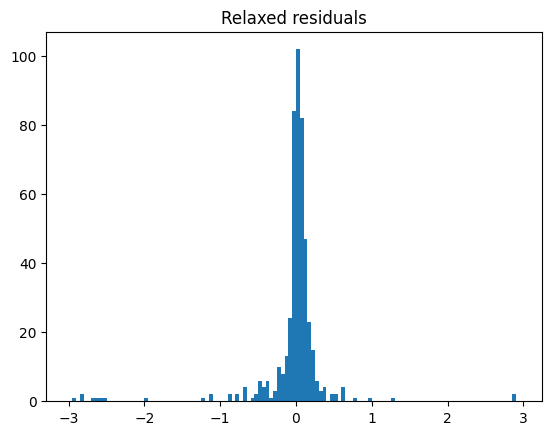

In [100]:
tp = TxoaProblem(tdoa)
tp.solve_for_offset(OffsetSolver95)
tp.bundle(steps=100)
tp.ransac_expand_to_all_rows()
tp.bundle(steps=100)
plt.hist(tp.get_residuals().flatten(),np.arange(-3,3,0.05));
plt.title("Relaxed residuals")

Text(0.5, 1.0, 'Reconstruction distance residuals')

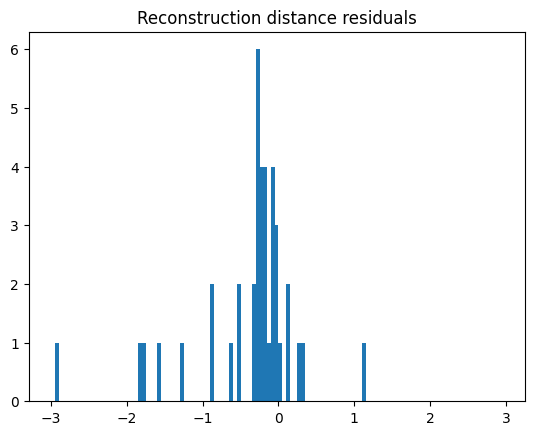

In [101]:
R,S = tp.upgrade(ransac_iter=1000, tol=0.1)
est = np.sqrt(np.sum((np.expand_dims(R.T,1) - np.expand_dims(S.T,0))**2,axis=2))
res = tp.data - tp.sol.o - est
plt.hist((res).flatten(), bins=np.arange(-3,3,0.05));
plt.title("Reconstruction distance residuals")

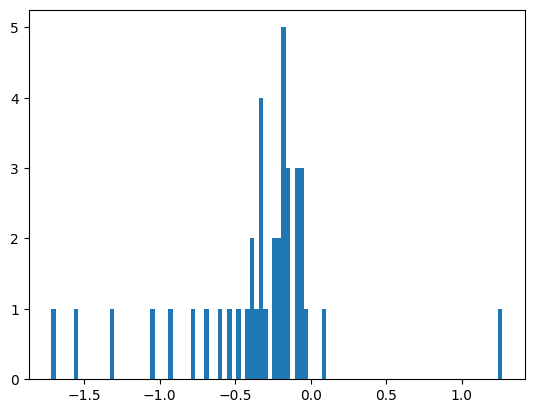

In [102]:
plt.hist((offsets_gt - tp.sol.o).flatten(),100);